In [1]:
import sys
import torch
import ot

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../lib")
from distributions import sampleWrappedNormal
from utils_hyperbolic import *
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare
from sw import sliced_wasserstein
from utility import *
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def sampleWrappedNormal_mix(n=1000,n_mix=8,r=1,origin=False):

    if origin==False:
        mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
        Sigma0 = torch.eye(2, dtype=torch.float, device=device)*0.1
        n_mix_ = int(n/n_mix)

        x0 = torch.from_numpy(np.array([1,0,0])).to(device)
        t = torch.tensor([0.5], dtype=torch.float64, device=device)

        X = sampleWrappedNormal(mu0, Sigma0, n)
        for i in range(n_mix):
            v = torch.from_numpy(np.array([0,np.cos(2*np.pi/n_mix*i),np.sin(2*np.pi/n_mix*i)])/np.sqrt(2)).to(device)
            mu = torch.cosh(t) * x0 + torch.sinh(t) * v/torch.linalg.norm(v)
            X[(i*n_mix_):(i*n_mix_+n_mix_),:] = sampleWrappedNormal(mu, Sigma0, n_mix_)
        
    else:
        mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
        Sigma0 = torch.eye(2, dtype=torch.float, device=device)*0.1
        n_ = int(n*0.8)
        n_mix_ = int(n_/n_mix)

        x0 = torch.from_numpy(np.array([1,0,0])).to(device)
        t = torch.tensor([0.5*r], dtype=torch.float64, device=device)
        v = torch.from_numpy(np.array([0,1,1])/np.sqrt(2)).to(device)
        mu0 = torch.cosh(t) * x0 + torch.sinh(t) * v/torch.linalg.norm(v)

        X = sampleWrappedNormal(mu0, Sigma0, n)
        for i in range(n_mix):
            v = torch.from_numpy(np.array([0,np.cos(2*np.pi/n_mix*i),np.sin(2*np.pi/n_mix*i)])/np.sqrt(2)).to(device)
            mu = torch.cosh(t) * x0 + torch.sinh(t) * v/torch.linalg.norm(v)
            X[(i*n_mix_):(i*n_mix_+n_mix_),:] = sampleWrappedNormal(mu, Sigma0, n_mix_)
        
    return X



def sampleNormal_mix(n=1000,n_mix=8,r=1,origin=False,std=0.5,device=device):

    if origin==False:
        n_mix_ = int(n/n_mix)
        mm = torch.tensor([0,0],dtype=torch.float64,device=device)
        X = torch.randn(n,2).to(device)+mm
        for i in range(n_mix):
            mm = torch.from_numpy(np.array([np.cos(2*np.pi/n_mix*i),np.sin(2*np.pi/n_mix*i)])).to(device)
            v = 0.005*torch.randn(n_mix_,2).to(device) + mm*std
            X[(i*n_mix_):(i*n_mix_+n_mix_),:] = v
        
    else:
        n_ = int(n*0.96)
        n_mix_ = int(n_/n_mix)
        mm = torch.tensor([std*r,0],dtype=torch.float64,device=device)
        X = 0.005*torch.randn(n,2).to(device) + mm
        for i in range(n_mix):
            mm = torch.from_numpy(np.array([np.cos(2*np.pi/n_mix*i),np.sin(2*np.pi/n_mix*i)])).to(device)
            v = 0.005*torch.randn(n_mix_,2).to(device) + mm*std
            X[(i*n_mix_):(i*n_mix_+n_mix_),:] = v
        
    return X


def sampleCircle_mix(n=1000,r=1,origin=False,std=0.5,device=device):

    if origin==False:
        mm = torch.tensor([0,0],dtype=torch.float64,device=device)
        X = torch.randn(n,2).to(device)+mm
        for i in range(n):
            mm = torch.from_numpy(np.array([np.cos(2*np.pi/n*i),np.sin(2*np.pi/n*i)])).to(device)
            X[i,:] = mm*std
        
    else:
        mm = torch.tensor([std*r,0],dtype=torch.float64,device=device)
        X = 0*torch.randn(n,2).to(device) + mm
        n_ = int(0.8*n)
        for i in range(n_):
            mm = torch.from_numpy(np.array([np.cos(2*np.pi/n_*i),np.sin(2*np.pi/n_*i)])).to(device)
            X[i,:] = mm*std
        
    return X

## Poincare Model

In [3]:
RR = np.arange(-1,1+1e-10,0.1)
n_try = 10
n = 1000

L_w = np.zeros((len(RR), n_try))
L_hhsw = np.zeros((len(RR), n_try))
L_sfw = np.zeros((len(RR), n_try))

i = 0

t_w = 0 
t_hhsw = 0
t_sfw = 0


for i, r in enumerate(RR):
    for k in range(n_try):
        
        x0 = sampleCircle_mix(n=n,r=1,origin=False,std=0.2,device=device)
        x1 = sampleCircle_mix(n=n,r=r,origin=True,std=0.2,device=device)


        torch.cuda.synchronize()
        t0 = time.time()
        distance = horo_hyper_sliced_wasserstein_poincare(x0, x1, 2000, device, p=2)
        L_hhsw[i,k] = distance.item()
        torch.cuda.synchronize()
        t_hhsw += time.time()-t0


        torch.cuda.synchronize()
        t0 = time.time()
        distance = SFW(x0,x1,hyperbolic_model="Poincare",spf_curve="Hm_p")
        L_sfw[i,k] = distance.item()**2
        torch.cuda.synchronize()
        t_sfw += time.time()-t0

        
        torch.cuda.synchronize()
        t0 = time.time()
        a = torch.ones((n,), device=device)/n
        b = torch.ones((n,), device=device)/n
        M = dist_poincare2(x0,x1)**2
        distance = ot.emd2(a, b, M)
        L_w[i,k] = distance.item()
        torch.cuda.synchronize()
        t_w += time.time()-t0

    
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/tmp/ipykernel_3143330/2789989411.py:45: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_3143330/2789989411.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[1].set_ylim(0,1.4)


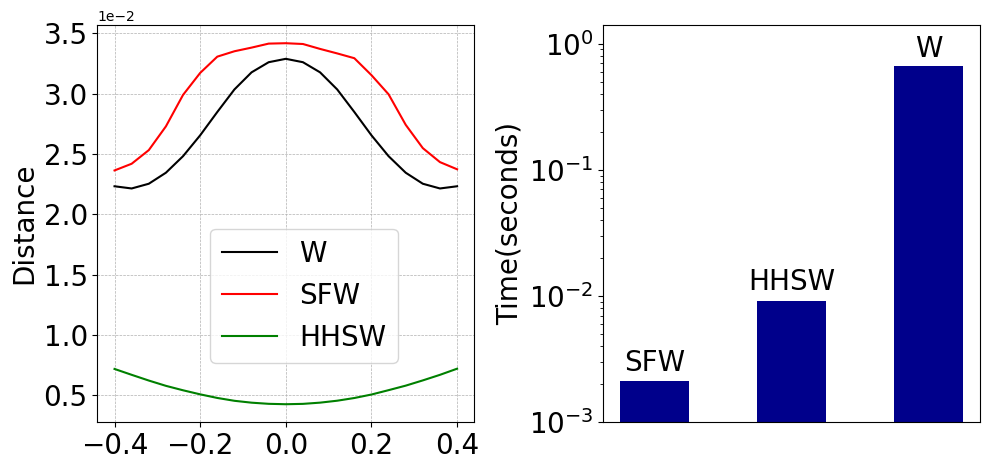

In [4]:
title_size = 20
abc_size = 30
cy = 'coral'
cx = 'mediumslateblue'
lim = 0.35
tick = 0.3
plt.style.use('default')  

L_w_m = np.mean(L_w,1)
L_hhsw_m = np.mean(L_hhsw,1)
L_sfw_m = np.mean(L_sfw,1)




x0 = sampleCircle_mix(n=n,r=1,origin=False,std=0.2,device=device)
x1 = sampleCircle_mix(n=n,r=0.6,origin=True,std=0.2,device=device)

# plt.figure(2, figsize=(20, 5.3))
fig, axs = plt.subplots(1,2,figsize=(10, 4.8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)



plt.subplot(1, 2, 1)
x_ticks = np.arange(-1,1+1e-10,0.5)*0.4
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Distance',fontsize=20)
plt.plot(np.arange(-1,1+1e-10,0.1)*0.4,L_w_m,c='k',label='W',markersize=10)
plt.plot(np.arange(-1,1+1e-10,0.1)*0.4,L_sfw_m,c='r',label='SFW',markersize=10)
plt.plot(np.arange(-1,1+1e-10,0.1)*0.4,L_hhsw_m,c='g',label='HHSW',markersize=10)
axs[0].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(loc=(0.3,0.15),fontsize=20)
dist = ('SFW', 'HHSW', 'W')
times = [t_sfw/(RR.shape[0]*n_try),t_hhsw/(RR.shape[0]*n_try),t_w/(RR.shape[0]*n_try)]

plt.subplot(1,2,2)
plt.bar(dist, times, color='darkblue', width=0.5, bottom=0.001)
plt.ylabel('Time(seconds)',fontsize=20)
plt.yticks([0,0.05,0.10,0.15],fontsize=20)
# plt.xticks(rotation=60,fontsize=20)
plt.xticks([])
axs[1].set_yscale('log')

tt = np.array([0.0023,0.01,0.7])
for i in range(3):
    plt.annotate(dist[i], xy=(i,tt[i]), ha='center', va='bottom', fontsize=20)
# axs[3].bar_label(axs[3].containers[0], label_type='edge', color='red', rotation=90, fontsize=7, padding=3)
axs[1].set_ylim(0,1.4)

plt.tight_layout()
# plt.savefig("../results/motiva.pdf", format="pdf", bbox_inches="tight")
plt.show()
